# NYC Tree Data Cleaning

### In this notebook, we'll attempt to clean as much as possible the '2015 Street Tree Census - Tree Data' dataset. We have a sample of 100.000 rows instead of the original 684.000 rows.

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon
from shapely import wkt
sns.set_theme(style="darkgrid")

In [112]:
df = pd.read_csv('data_100000.csv')
df.head()

,created_at,tree_id,block_id,the_geom,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,...,st_assem,st_senate,nta,nta_name,boro_ct,state,latitude,longitude,x_sp,y_sp
0,08/27/2015,180683,348711,POINT (-73.84421521958048 40.723091773924274),3,0,OnCurb,Alive,Fair,Acer rubrum,...,28,16,QN17,Forest Hills,4073900,New York,40.723092,-73.844215,1.027431e+06,202756.768749
1,09/03/2015,200540,315986,POINT (-73.81867945834878 40.79411066708779),21,0,OnCurb,Alive,Fair,Quercus palustris,...,27,11,QN49,Whitestone,4097300,New York,40.794111,-73.818679,1.034456e+06,228644.837379
2,09/05/2015,204026,218365,POINT (-73.93660770459083 40.717580740099116),3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,50,18,BK90,East Williamsburg,3044900,New York,40.717581,-73.936608,1.001823e+06,200716.891267
3,09/05/2015,204337,217969,POINT (-73.93445615919741 40.713537494833226),10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,53,18,BK90,East Williamsburg,3044900,New York,40.713537,-73.934456,1.002420e+06,199244.253136
4,08/30/2015,189565,223043,POINT (-73.97597938483258 40.66677775537875),21,0,OnCurb,Alive,Good,Tilia americana,...,44,21,BK37,Park Slope-Gowanus,3016500,New York,40.666778,-73.975979,9.909138e+05,182202.425999


In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 42 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   created_at  100000 non-null  object 
 1   tree_id     100000 non-null  int64  
 2   block_id    100000 non-null  int64  
 3   the_geom    100000 non-null  object 
 4   tree_dbh    100000 non-null  int64  
 5   stump_diam  100000 non-null  int64  
 6   curb_loc    100000 non-null  object 
 7   status      100000 non-null  object 
 8   health      95007 non-null   object 
 9   spc_latin   95008 non-null   object 
 10  spc_common  95008 non-null   object 
 11  steward     95008 non-null   object 
 12  guards      95008 non-null   object 
 13  sidewalk    95008 non-null   object 
 14  user_type   100000 non-null  object 
 15  problems    95008 non-null   object 
 16  root_stone  100000 non-null  object 
 17  root_grate  100000 non-null  object 
 18  root_other  100000 non-null  object 
 19  trn

It seems like we have 4992 rows with some missing values for the columns 'health', 'spc_latin', 'spc_common', 'steward', 'guards', 'problems' and 'sidewalk_damage'. We might me tempted to delete those rows with NaN values but actually all those rows belong to either a 'stump' or 'dead' tree. Thus, it makes sense that they don't have any values for those columns. We should keep them.

In [114]:
df.status.value_counts()

Alive    95008
Stump     2831
Dead      2161
Name: status, dtype: int64

In [115]:
df_alive=df[df['status']=='Alive']
df_alive[df_alive.isnull().any(axis=1)]

,created_at,tree_id,block_id,the_geom,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,...,st_assem,st_senate,nta,nta_name,boro_ct,state,latitude,longitude,x_sp,y_sp
32794,09/21/2015,245041,413012,POINT (-74.21641202587655 40.54859739520807),16,0,OnCurb,Alive,NaN,Fraxinus pennsylvanica,...,62,24,SI32,Rossville-Woodrow,5020801,New York,40.548597,-74.216412,924106.880773,139219.632044


1 row has the 'health' variable missing.

We only keep the information concerning the location of each tree.

In [116]:
df.steward.value_counts()

None       65996
1or2       24170
3or4        4500
4orMore      342
Name: steward, dtype: int64

In [117]:
def steward_clean(x):
    if x == 'None':
        return '0'
    elif x == '1or2':
        return '1 or 2'
    elif x == '3or4':
        return '3 or 4'
    elif x == '4orMore':
        return '4 or more'
df['steward'] = df['steward'].apply(lambda x: steward_clean(x))   

In [118]:
df = df.drop(['the_geom', 'state', 'zip_city', 'x_sp', 'y_sp', 'address', 'boroname', 'boro_ct', 'cb_num', 'st_assem', 'st_senate', 'nta_name', 'cncldist'], 1)

We'll drop all columns not necesarry for machine learning. We will only keep information directly related to the tree.

In [119]:
df = df.drop(['created_at', 'tree_id', 'block_id', 'spc_latin', 'user_type', 'problems'], 1)

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   tree_dbh    100000 non-null  int64  
 1   stump_diam  100000 non-null  int64  
 2   curb_loc    100000 non-null  object 
 3   status      100000 non-null  object 
 4   health      95007 non-null   object 
 5   spc_common  95008 non-null   object 
 6   steward     95008 non-null   object 
 7   guards      95008 non-null   object 
 8   sidewalk    95008 non-null   object 
 9   root_stone  100000 non-null  object 
 10  root_grate  100000 non-null  object 
 11  root_other  100000 non-null  object 
 12  trnk_wire   100000 non-null  object 
 13  trnk_light  100000 non-null  object 
 14  trnk_other  100000 non-null  object 
 15  brnch_ligh  100000 non-null  object 
 16  brnch_shoe  100000 non-null  object 
 17  brnch_othe  100000 non-null  object 
 18  zipcode     100000 non-null  int64  
 19  bor

As 'sidewalk' has two values: 'NoDamage' or 'Damage'. I replace it a new one called 'sidewalk_damage' with 'Yes' or 'No'. It seems clearer this way.

In [121]:
def damage(x):
    if x =='NoDamage':
        return 'No'
    elif x =='Damage':
        return 'Yes'
df['sidewalk_damage'] = df['sidewalk'].apply(lambda x: damage(x))
df = df.drop(['sidewalk'], 1)

Let's change the name of some columns so it's clearer to understand what information they contain.

In [122]:
df = df.rename(columns={
    'brnch_othe': 'branch_other',
    'brnch_shoe': 'branch_shoe',
    'brnch_ligh': 'branch_light',
    'trnk_wire': 'trunk_wire',
    'trnk_light': 'trunk_light',
    'trnk_other': 'trunk_other'
    })

I clean the 'spc_common' values (capitalize, replace, ...).

In [123]:
df['spc_common'] = df['spc_common'].str.capitalize().str.replace("-", " ")

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   tree_dbh         100000 non-null  int64  
 1   stump_diam       100000 non-null  int64  
 2   curb_loc         100000 non-null  object 
 3   status           100000 non-null  object 
 4   health           95007 non-null   object 
 5   spc_common       95008 non-null   object 
 6   steward          95008 non-null   object 
 7   guards           95008 non-null   object 
 8   root_stone       100000 non-null  object 
 9   root_grate       100000 non-null  object 
 10  root_other       100000 non-null  object 
 11  trunk_wire       100000 non-null  object 
 12  trunk_light      100000 non-null  object 
 13  trunk_other      100000 non-null  object 
 14  branch_light     100000 non-null  object 
 15  branch_shoe      100000 non-null  object 
 16  branch_other     100000 non-null  objec

In [125]:
df.to_csv('nyc_trees_clean')

Top 10 trees in NY (based on frequency)

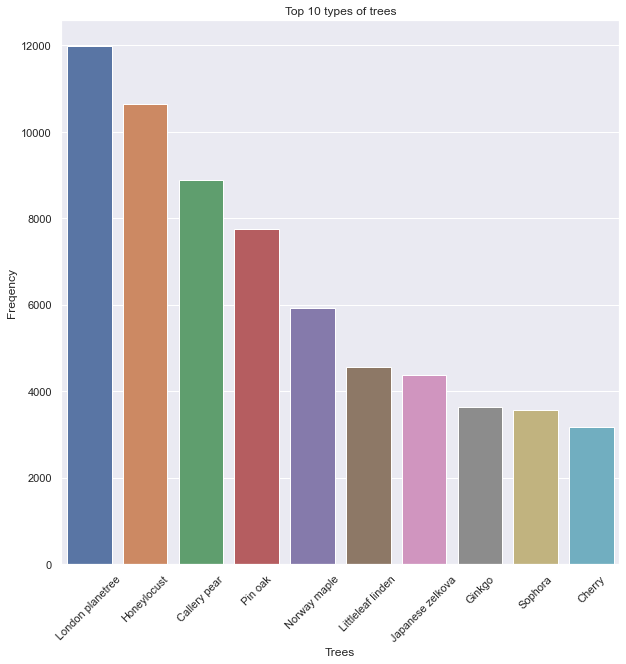

In [57]:
fig,ax = plt.subplots(figsize=(10,10))
ax = sns.countplot(x="spc_common", data=df, order=df.spc_common.value_counts().iloc[:10].index)
plt.title('Top 10 types of trees')
plt.xlabel('Trees')
plt.ylabel('Freqency')
ticks = plt.setp(ax.get_xticklabels(),rotation=45)

Are trees mostly alive, dead or stumps?

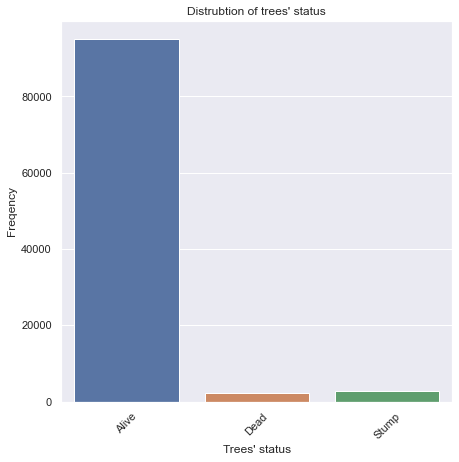

In [46]:
fig,ax = plt.subplots(figsize=(7,7))
ax = sns.countplot(x="status", data=df)
plt.title("Distrubtion of trees' status")
plt.xlabel("Trees' status")
plt.ylabel('Freqency')
ticks = plt.setp(ax.get_xticklabels(),rotation=45)

In [14]:
street_map = gpd.read_file('geo_export_1b5749c9-fabe-41cb-8bc2-9743c91a3cfc.shp')

In [26]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

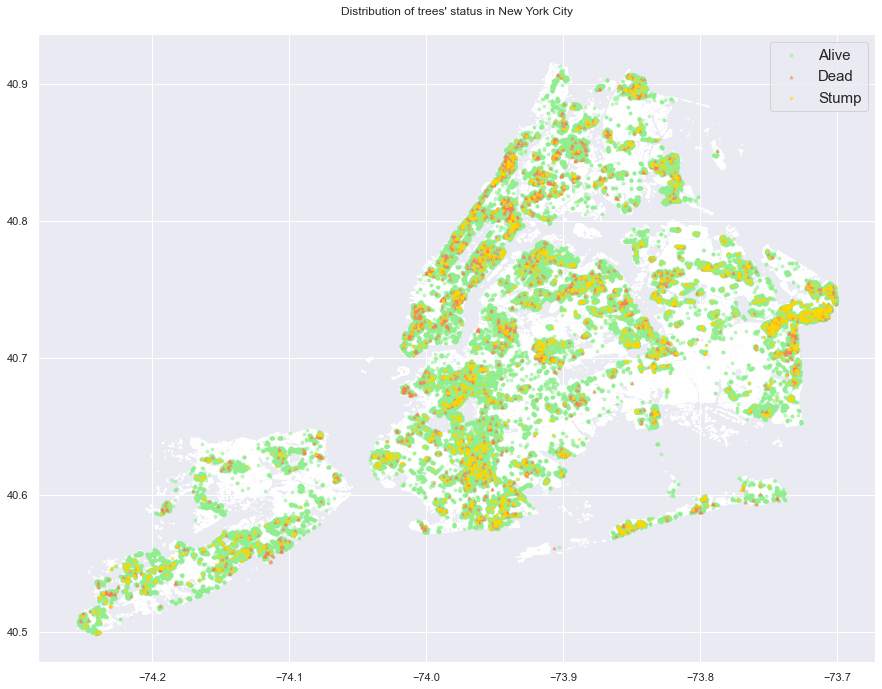

In [61]:
fig, ax = plt.subplots(figsize= (15,15))
street_map.plot (ax =ax, color='white')
gdf[gdf['status']=='Alive'].plot(ax=ax, color='lightgreen', markersize = 8, marker ='o', alpha=.5, label='Alive')
gdf[gdf['status']=='Dead'].plot(ax=ax, color='coral', markersize = 8, marker ='^', alpha=.5, label='Dead')
gdf[gdf['status']=='Stump'].plot(ax=ax, color='gold', markersize = 8, marker ='s', alpha=.5, label='Stump')
ax.set_title("Distribution of trees' status in New York City", pad=20)
plt.legend(prop={'size':15})